# Classifying images from Fashion MNIST using feedforward neural networks

Dataset source: https://github.com/zalandoresearch/fashion-mnist
Detailed tutorial: https://jovian.ml/aakashns/04-feedforward-nn

### Steps Included
- Importing Libraies
- Preparing the Data for NN
- Creating a Model
- Training Pipeline for GPU
- Traing the Model
- Get the Predictions on Samples
- Save the model

## Importing Libraies

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## Preparing the Dataset for NN

In [2]:
dataset = FashionMNIST(root='data/', download=True, transform = ToTensor())
test_dataset =FashionMNIST(root='data/', train=False, transform = ToTensor())

In [3]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

Load these datasets using `DataLoader` to make it ready for training and validating.

In [4]:
# Defining Batch Size
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True,  pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, shuffle=True,  pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size*2, shuffle=True, pin_memory=True)

Visualize the batch form the train dataset loader.

for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

Our datasets are ready for training and testing. Now we can start the modelng part.

## Creating a Model

In [5]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
class MnistModel(nn.Module):
  def __init__(self, in_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size,16)    # Hidden layer 01
    self.linear2 = nn.Linear(16,32)         # Hidden layer 02
    self.linear3 = nn.Linear(32, out_size)  # Output layer

  def forward(self, xb):
    out = xb.view(xb.size(0),-1)        # Flatten the image tensors
    out1 = self.linear1(out)             # Intermidiate outputs of hidden layer 1
    out1 = F.relu(out1)                   # Apply ReLU activation function
    out2 = self.linear2(out1)             # Intermediate outputs of hidden layer 2
    out2 = F.relu(out2)                   # Apply ReLU activation function
    out = self.linear3(out2)
    return out  

  def training_step(self, batch):
    images, labels =batch
    out=self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss":loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses =[x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f} , val_acc: {:.4f}".format(epoch, result["val_loss"], result["val_acc"]))


## Creating Pipeline for GPU

In [7]:
torch.cuda.is_available()

True

In [24]:
# Pick GPU if availabe, else use CPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [9]:
# Move tensor(s) or data to the availabe device
def to_device(data, device):
  if isinstance(data, (list,tuple)):
     return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [11]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the Model

In [12]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [13]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # validation step
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [14]:
input_size = 784
num_classes  = 10
model =MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [15]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.301844358444214, 'val_acc': 0.1162109375}]

In [16]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6349 , val_acc: 0.7668
Epoch [1], val_loss: 0.7415 , val_acc: 0.7250
Epoch [2], val_loss: 0.6007 , val_acc: 0.7748
Epoch [3], val_loss: 0.4996 , val_acc: 0.8104
Epoch [4], val_loss: 0.5083 , val_acc: 0.8091


In [17]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3942 , val_acc: 0.8553
Epoch [1], val_loss: 0.3898 , val_acc: 0.8581
Epoch [2], val_loss: 0.4062 , val_acc: 0.8536
Epoch [3], val_loss: 0.4004 , val_acc: 0.8606
Epoch [4], val_loss: 0.3762 , val_acc: 0.8636


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

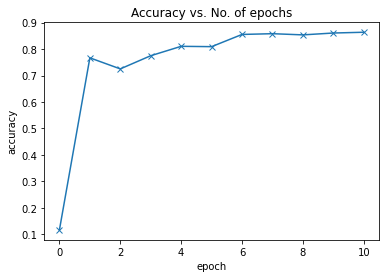

In [18]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs. No. of epochs")

Text(0.5, 1.0, 'Losses vs. No. of epochs')

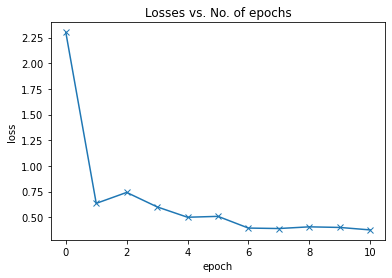

In [19]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Losses vs. No. of epochs")

## Prediction on random sample

In [20]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: Trouser , Predicted: Trouser


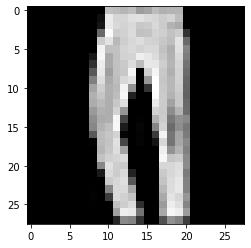

In [21]:
img, label = test_dataset[5]
plt.imshow(img[0], cmap='gray')
print("Label:", dataset.classes[label], ", Predicted:", 
      dataset.classes[predict_image(img, model)])

In [22]:
evaluate(model, test_loader)

{'val_loss': 0.4187077581882477, 'val_acc': 0.8497070074081421}

## Save and Upload

In [23]:
saved_weights_fname='fashion-feedforward.pth'
torch.save(model.state_dict(), saved_weights_fname)